In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path

In [48]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to your folder in Google Drive
# Change "YourFolderPath" to the actual path inside MyDrive
data_dir = '/content/drive/MyDrive/Datafiles'

# Get all CSV file paths
csv_files = glob.glob(f"{data_dir}/*.csv")  # matches only .csv files in Datafiles folder

# Check how many files were found
print(f"Number of CSV files found: {len(csv_files)}")
print("First 5 file paths:", csv_files[:5])  # preview some paths

# Read each CSV into a DataFrame and store in a list
dfs = []
for f in sorted(csv_files):  # sorted to keep order consistent
    df_temp = pd.read_csv(f)
    df_temp['source_file'] = Path(f).name  # optional: keep track of which file each row came from
    dfs.append(df_temp)

# Combine all CSVs into one DataFrame
df = pd.concat(dfs, axis=0, ignore_index=True)

# Check the combined DataFrame
print("Combined shape:", df.shape)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of CSV files found: 50
First 5 file paths: ['/content/drive/MyDrive/Datafiles/sales_week_starting_2012-10-15.csv', '/content/drive/MyDrive/Datafiles/sales_week_starting_2013-05-20.csv', '/content/drive/MyDrive/Datafiles/sales_week_starting_2013-08-12.csv', '/content/drive/MyDrive/Datafiles/sales_week_starting_2013-04-29.csv', '/content/drive/MyDrive/Datafiles/sales_week_starting_2013-08-05.csv']
Combined shape: (204329, 3)


,sale_time,purchaser_gender,source_file
0,2012-10-01 01:42:22,female,sales_week_starting_2012-10-01.csv
1,2012-10-01 02:24:53,female,sales_week_starting_2012-10-01.csv
2,2012-10-01 02:25:40,female,sales_week_starting_2012-10-01.csv
3,2012-10-01 02:30:42,female,sales_week_starting_2012-10-01.csv
4,2012-10-01 02:51:32,male,sales_week_starting_2012-10-01.csv


## Question1) Plot daily sales for all 50 weeks.

In [49]:
FIG_SIZE = (8,6)

In [51]:
sale_day = pd.to_datetime(df['sale_time'])

In [52]:
daily_sales_df = sale_day.groupby(sale_day.dt.floor('d')).size().reset_index(name='sales_amount')
daily_sales_df.rename(columns={'sale_time':'sale_day'},inplace=True)
daily_sales_df.head()

,sale_day,sales_amount
0,2012-10-01,514
1,2012-10-02,482
2,2012-10-03,499
3,2012-10-04,546
4,2012-10-05,476


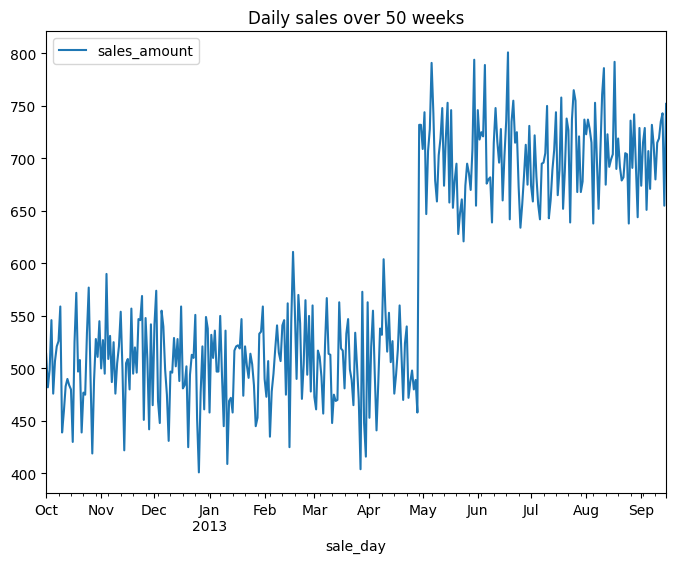

In [53]:
#  to use index in plotting make sale_day index
daily_sales_df.index = daily_sales_df['sale_day']
daily_sales_df.drop(columns=['sale_day'], inplace=True)

#  plot daily sales for all 50 weeks
daily_sales_df.plot(figsize=FIG_SIZE, title = "Daily sales over 50 weeks")
plt.show()

## Question 2) It looks like there has been a sudden change in daily sales. What date did it occur?

In [54]:
# compare sales amount difference with the previous day and find the biggest difference
# which should give the sudden change in the plot
daily_sales_df['prev_day_sale_amount'] = [None] + daily_sales_df['sales_amount'].to_list()[:-1]
daily_sales_df['difference_btw_prev_day'] = daily_sales_df['sales_amount'] - daily_sales_df['prev_day_sale_amount']
daily_sales_df.head()

,sales_amount,prev_day_sale_amount,difference_btw_prev_day
sale_day,,,
2012-10-01,514,NaN,NaN
2012-10-02,482,514.0,-32.0
2012-10-03,499,482.0,17.0
2012-10-04,546,499.0,47.0
2012-10-05,476,546.0,-70.0


In [55]:
# get the index of max change to answer what date did it occur
max_change_date = daily_sales_df['difference_btw_prev_day'].idxmax()
daily_sales_df.loc[[max_change_date]]

,sales_amount,prev_day_sale_amount,difference_btw_prev_day
sale_day,,,
2013-04-29,732,458.0,274.0


## Question 3) Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?

In [56]:
from scipy import stats

# Define the date at which the largest change in daily sales was observed
change_date = '2013-04-29'

# Split the dataset into two groups: one before the change date and one after (inclusive)
# Since the DataFrame index contains datetime values, direct comparison is valid
before = daily_sales_df[daily_sales_df.index < change_date]['sales_amount']
after = daily_sales_df[daily_sales_df.index >= change_date]['sales_amount']

# Perform a two-sample Welch’s t-test to evaluate whether the difference
# in average daily sales between the two periods is statistically significant.
# We assume unequal variance between the two groups by setting equal_var=False
t_stat, p_value = stats.ttest_ind(before, after, equal_var=False)

print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: -45.943533193935615
p-value: 3.487246853115062e-138


The obtained p-value as the result of the two-sample t-test is 3.81e-138, which is significantly lower than the conventional threshold of 0.05. This extremely small p-value provides strong statistical evidence that the difference in daily sales before and after the change date is not due to random chance. Therefore, we can confidently conclude that this particular date marks a statistically significant shift in sales behavior, and it is indeed important for further analysis.

## Question 4) Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? Please use plots to support your answer (a rigorous statistical analysis is not necessary).

In [57]:
import pandas as pd

In [59]:
df['sale_day'] = pd.to_datetime(df['sale_time']).dt.floor('d')
gender_portions_df = df.groupby(['sale_day', 'purchaser_gender']).size().reset_index(name='sales_amount')

In [60]:
gender_portions_df

,sale_day,purchaser_gender,sales_amount
0,2012-10-01,female,413
1,2012-10-01,male,101
2,2012-10-02,female,379
3,2012-10-02,male,103
4,2012-10-03,female,386
...,...,...,...
695,2013-09-13,male,537
696,2013-09-14,female,193
697,2013-09-14,male,462
698,2013-09-15,female,230


In [61]:
# calculate female and male sales amount separately
new_df = pd.DataFrame(gender_portions_df['sale_day'].unique(),columns=['sale_day'])
new_df['female_sales_amount'] = pd.Series(gender_portions_df[gender_portions_df.purchaser_gender == 'female']['sales_amount']).reset_index(drop=True)
new_df['male_sales_amount'] = pd.Series(gender_portions_df[gender_portions_df.purchaser_gender == 'male']['sales_amount']).reset_index(drop=True)
new_df[-5:]

,sale_day,female_sales_amount,male_sales_amount
345,2013-09-11,224,495
346,2013-09-12,225,510
347,2013-09-13,206,537
348,2013-09-14,193,462
349,2013-09-15,230,522


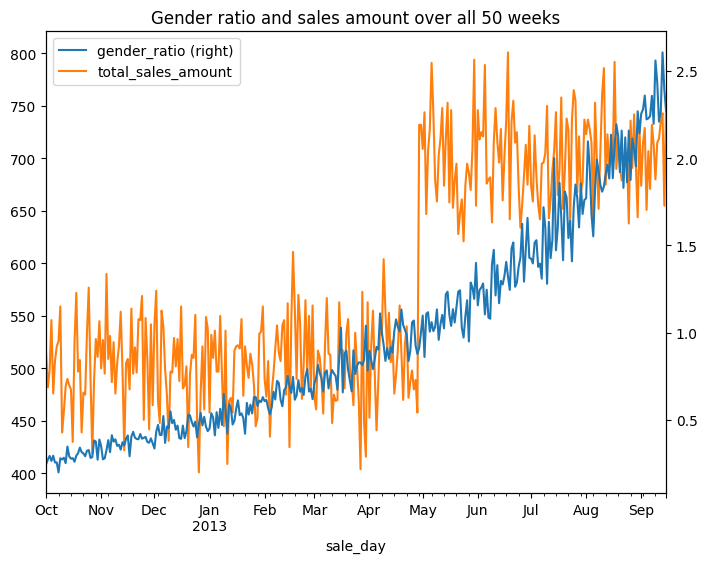

In [62]:
# calculate gender ratio of sales
new_df['gender_ratio'] = new_df['male_sales_amount']/new_df['female_sales_amount']

# plot gender ratio change over 50 weeks with the total sales amount
# observe if there is a correlation between them
plot_df = new_df.copy()
plot_df['total_sales_amount']  = plot_df['male_sales_amount'] + plot_df['female_sales_amount']
plot_df.drop(columns=['female_sales_amount', 'male_sales_amount'], inplace=True)
plot_df.index = plot_df['sale_day']
plot_df.drop(columns=['sale_day'], inplace=True)
plot_df.plot(secondary_y = ['gender_ratio'],figsize=FIG_SIZE, title= "Gender ratio and sales amount over all 50 weeks")
plt.show()

The increasing trend of the male ratio in the sales amount does not explain the sudden change. The reason should be something different. For example, it might be caused by starting a new marketing campaign or adding a new feature to the website.

## Question 5) Assume a given day is divided into four dayparts: night (12:00AM - 6:00AM), morning (6:00AM to 12:00PM), afternoon (12:00PM to 6:00PM) and evening (6:00PM - 12:00AM). What is the percentage of sales in each daypart over all 50 weeks?

In [63]:
# extract sale hour to divide sales to the part of days
df['sale_hour']  = pd.to_datetime(df['sale_time']).dt.ceil('h').dt.hour
df.dtypes

,0
sale_time,object
purchaser_gender,object
source_file,object
sale_day,datetime64[ns]
sale_hour,int32


In [64]:
# define a function to apply sale hour column to decide a part of day based on the mentioned logic
def assign_day_part(sale_hour):
    """Assign labels based on sale hour."""
    if sale_hour >= 6 and sale_hour < 12:
        return 'morning'
    if sale_hour >= 12 and sale_hour < 18:
        return 'afternoon'
    if sale_hour >= 18 and sale_hour < 24:
        return 'evening'
    if sale_hour >= 0 and sale_hour < 6:
        return 'night'

In [65]:
# apply the defined function and create day_part column
df['day_part'] = df['sale_hour'].apply(assign_day_part)

# drop unnecessary columns
df.drop(columns = ['purchaser_gender', 'sale_hour', 'sale_time'], inplace= True)

In [66]:
# calculate sales amount per day part
df_pct_sales = df.groupby(df.day_part).size().reset_index(name='day_part_sales_amount')

# calculate sales amount percentage per day part
df_pct_sales['day_part_sales_percentage'] = df_pct_sales['day_part_sales_amount'] / df_pct_sales['day_part_sales_amount'].sum()

In [67]:
df_pct_sales

,day_part,day_part_sales_amount,day_part_sales_percentage
0,afternoon,81159,0.397198
1,evening,53523,0.261945
2,morning,56080,0.274459
3,night,13567,0.066398
